In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import tensorflow as tf
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import MaxPooling3D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.layers import Reshape
from keras.layers import BatchNormalization
from keras.layers import GRU
from keras.layers import AveragePooling2D

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras.optimizers as ops

In [3]:
#creation de la fonction qui va traiter les donnees
def reg_data(df):
    df = df.drop(df.index[[0,1,2]])
    df = df.drop('MW', axis=1)
    df.columns = ['Date', 'From', 'to', 'MW']

    dates = df['Date'].tolist()
    days = []
    months = []
    years = []
    for date in dates:
        days.append(date.split('.')[0])
        months.append(date.split('.')[1])
        years.append(date.split('.')[2])

    df['Day'] = days
    df['Month'] = months
    df['Year'] = years

    def fixMW(cols):
        TT = cols
        TT = TT.replace('.','')
        TT = TT.replace(',','.')
        return TT

    df['MW'] = df['MW'].apply(fixMW).astype(float)
    df['Day'] = df['Day'].astype(int)
    df['Month'] = df['Month'].astype(int)
    df['Year'] = df['Year'].astype(int)

    df = df.groupby(['Day','Month','Year'])['MW'].sum()
    df = pd.DataFrame(df)
    df['Month'] = df.index.get_level_values('Month')
    df['Day'] = df.index.get_level_values('Day')
    df['Year'] = df.index.get_level_values('Year')
    df.reset_index(drop=True, inplace=True)
    return df

#appel de la fonction reg_data


Data_10 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2010.csv',sep=';')
Data_10 = reg_data(Data_10)

Data_11 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2011.csv',sep=';')
Data_11 = reg_data(Data_11)

Data_12 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2012.csv',sep=';')
Data_12 = reg_data(Data_12)

Data_13 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2013.csv',sep=';')
Data_13 = reg_data(Data_13)

Data_14 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2014.csv',sep=';')
Data_14 = reg_data(Data_14)
Data_15 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2015.csv',sep=';')
Data_15 = reg_data(Data_15)

Data_16 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2016.csv',sep=';')
Data_16 = reg_data(Data_16)

Data_17 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2017.csv',sep=';')
Data_17 = reg_data(Data_17)





#concatener tout les donnees dans une seule DataFrame
DataFrame = pd.concat([ Data_10, Data_11, Data_12, Data_13,Data_14, Data_15, Data_16, Data_17], ignore_index=True)


In [4]:
DataFrame.head()

,MW,Month,Day,Year
0,332.0,1,1,2010
1,1898.0,2,1,2010
2,2764.0,3,1,2010
3,12736.0,4,1,2010
4,8870.0,5,1,2010


In [5]:
#copier les donnees pour les conserver et travailler seulement avec la copie
model_data = DataFrame

In [6]:
#standarization des donnees
scaler = MinMaxScaler(feature_range=(0, 1))
model_data = scaler.fit_transform(model_data)

#creer une fonction qui va faire la fraction des donnees en Data_train and DataTest
def split_data(df):
    train_size = int(len(df) * 0.75)
    test_size = len(df) - train_size
    train, test = df[0:train_size,:], df[train_size:len(df),:]
    return train, test

#appel de la fonction "split data"
train, test = split_data(model_data)
print(len(model_data))
print(len(train))
print(len(test))

2922
2191
731


In [7]:
#creation de lafonction qui va fractionner les donnees Xtrain and Ytrain puis Xtest and Ytest
def Split_weekly(df, look_back=7):
	dataX, dataY = [], []
	for i in range(len(df)-look_back-1):
		a = df[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(df[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

#Appel de la fonction Split_weekly
Xtrain, Ytrain = Split_weekly(train)
Xtest, Ytest = Split_weekly(test)

print(len(Xtest))
print(len(Ytest))

print(len(Xtrain))
print(len(Ytrain))

723
723
2183
2183


In [8]:
#transformer la size des donnees en 3D
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

print(Xtest.shape[:])
print(Xtrain.shape[:])

model = Sequential()
model.add(GRU(units = 8, input_shape=(Xtrain.shape[1], 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units = 16))
model.add(Dropout(0.3))#drop out overfetting
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = ops.Nadam(lr=1e-3), loss = 'mse')


model_train_GRU = model.fit(Xtrain, Ytrain, validation_split=0.2, epochs=30, batch_size=8, verbose=1)

(723, 7, 1)
(2183, 7, 1)


Epoch 1/30
219/219 [==============================] - 8s 13ms/step - loss: 0.0496 - val_loss: 0.0822
Epoch 2/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0310 - val_loss: 0.0586
Epoch 3/30
219/219 [==============================] - 3s 12ms/step - loss: 0.0254 - val_loss: 0.0411
Epoch 4/30
219/219 [==============================] - 2s 10ms/step - loss: 0.0210 - val_loss: 0.0350
Epoch 5/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0194 - val_loss: 0.0386
Epoch 6/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0177 - val_loss: 0.0349
Epoch 7/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0175 - val_loss: 0.0327
Epoch 8/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0179 - val_loss: 0.0321
Epoch 9/30
219/219 [==============================] - 3s 11ms/step - loss: 0.0175 - val_loss: 0.0308
Epoch 10/30
219/219 [==============================] - 2s 10ms/step - loss: 0.0171 - val_loss: 0

In [9]:
def evaluate_model(model, X, Y):
    # Make predictions
    predictions = model.predict(X)

    # Calculate R^2 score
    r2 = r2_score(Y, predictions)

    # Calculate mean absolute error
    mae = mean_absolute_error(Y, predictions)

    return r2, mae


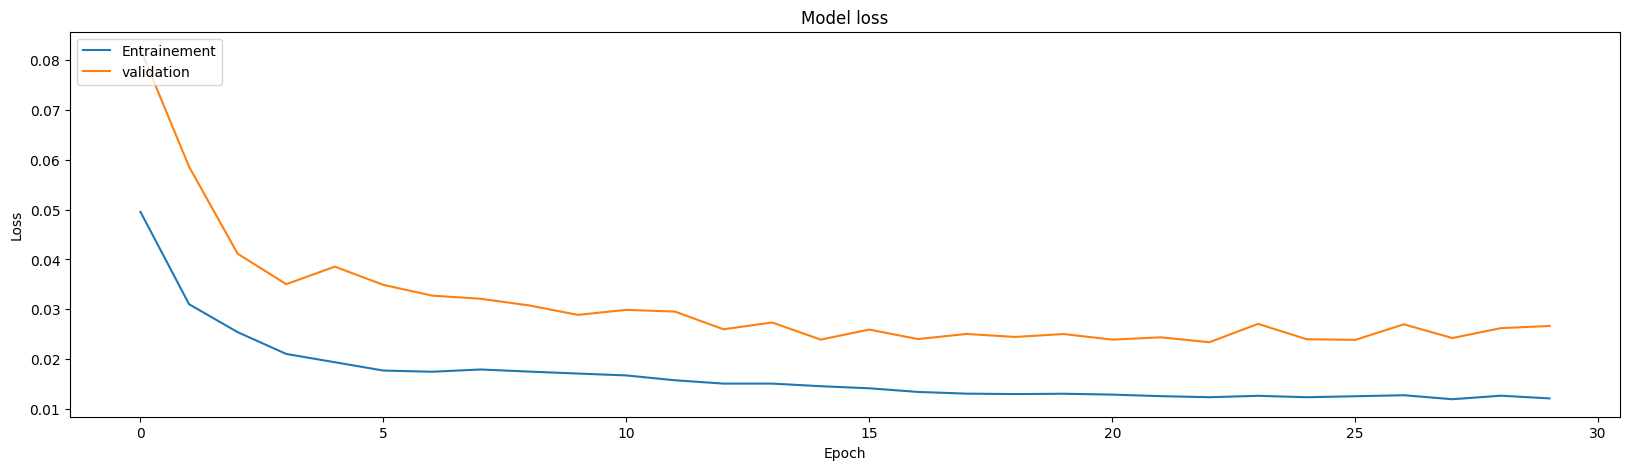

In [10]:
def ploter_Erreur(hist):
    f, axarr = plt.subplots(1,1, figsize=(20, 5))

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    axarr.set_title('Model loss')
    axarr.set_ylabel('Loss')
    axarr.set_xlabel('Epoch')
    axarr.legend(['Entrainement', 'validation'], loc='upper left')
    plt.show()


ploter_Erreur(model_train_GRU)

In [11]:
# # Evaluate model
r2_train, mae_train = evaluate_model(model, Xtrain, Ytrain)
r2_test, mae_test = evaluate_model(model, Xtest, Ytest)
print("Train R^2 Score:", r2_train)
print("Train MAE:", mae_train)
print("Test R^2 Score:", r2_test)
print("Test MAE:", mae_test)

23/23 [==============================] - 0s 3ms/step
Train R^2 Score: 0.6701287724971636
Train MAE: 0.0837986348363443
Test R^2 Score: 0.4400114452859408
Test MAE: 0.1502655379058502


### Now we'll try LSTM

In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Nadam

train, test = split_data(model_data)
print(len(model_data))
print(len(train))
print(len(test))
print("---------------------------")
Xtrain, Ytrain = Split_weekly(train)
Xtest, Ytest = Split_weekly(test)
print(len(Xtest))
print(len(Ytest))
print("---------------------------")
print(len(Xtrain))
print(len(Ytrain))

2922
2191
731
---------------------------
723
723
---------------------------
2183
2183


In [44]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

print(Xtest.shape[:])
print(Xtrain.shape[:])

model = Sequential()
model.add(LSTM(units=8, input_shape=(Xtrain.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=16))
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(Dense(1, activation='sigmoid'))

optimizer = Nadam(lr=1e-3)
model.compile(optimizer=optimizer, loss='mse')

(723, 7, 1)
(2183, 7, 1)


In [45]:
model_train_LSTM = model.fit(Xtrain, Ytrain, validation_split=0.2, epochs=100, batch_size=8, verbose=1)

Epoch 1/100
219/219 [==============================] - 9s 17ms/step - loss: 0.0491 - val_loss: 0.0827
Epoch 2/100
219/219 [==============================] - 3s 12ms/step - loss: 0.0337 - val_loss: 0.0776
Epoch 3/100
219/219 [==============================] - 2s 9ms/step - loss: 0.0326 - val_loss: 0.0753
Epoch 4/100
219/219 [==============================] - 2s 8ms/step - loss: 0.0299 - val_loss: 0.0717
Epoch 5/100
219/219 [==============================] - 2s 9ms/step - loss: 0.0272 - val_loss: 0.0505
Epoch 6/100
219/219 [==============================] - 2s 11ms/step - loss: 0.0233 - val_loss: 0.0427
Epoch 7/100
219/219 [==============================] - 2s 10ms/step - loss: 0.0206 - val_loss: 0.0427
Epoch 8/100
219/219 [==============================] - 2s 8ms/step - loss: 0.0185 - val_loss: 0.0382
Epoch 9/100
219/219 [==============================] - 2s 8ms/step - loss: 0.0177 - val_loss: 0.0350
Epoch 10/100
219/219 [==============================] - 2s 8ms/step - loss: 0.0174 - va

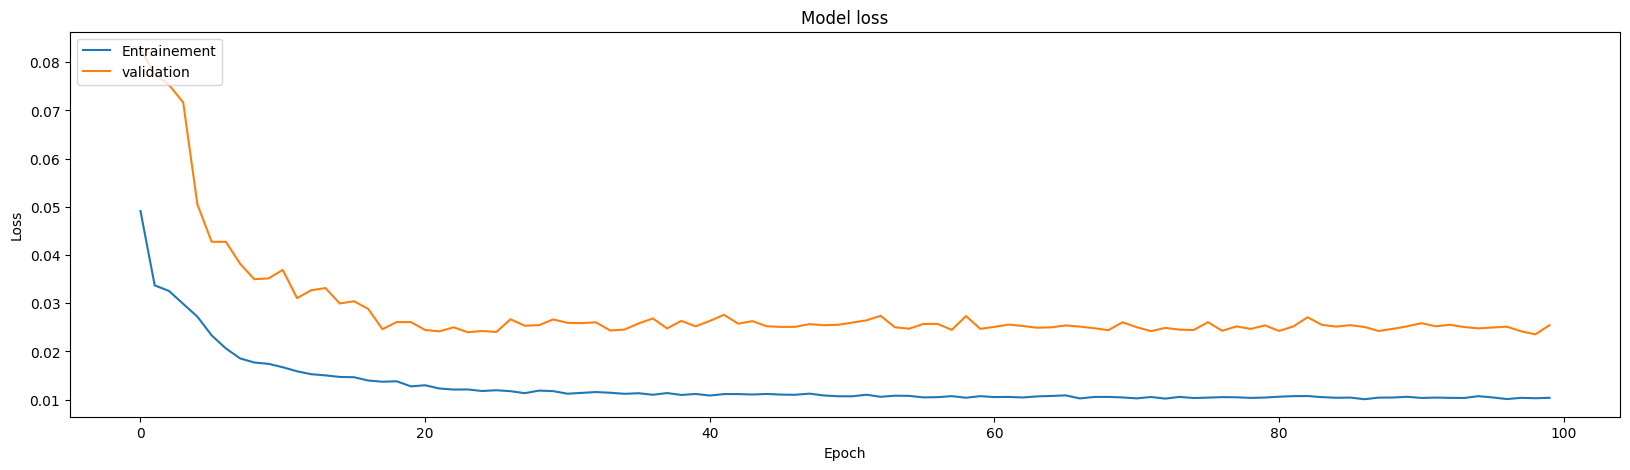

In [46]:
ploter_Erreur(model_train_LSTM)

In [16]:
# # Evaluate model
r2_train, mae_train = evaluate_model(model, Xtrain, Ytrain)
r2_test, mae_test = evaluate_model(model, Xtest, Ytest)
print("Train R^2 Score:", r2_train)
print("Train MAE:", mae_train)
print("Test R^2 Score:", r2_test)
print("Test MAE:", mae_test)

23/23 [==============================] - 0s 3ms/step
Train R^2 Score: 0.6896115051512535
Train MAE: 0.0811329261620698
Test R^2 Score: 0.4530201769761394
Test MAE: 0.1478863352326698



### Using Transformers

In [17]:
from transformers import TimeSeriesTransformerForPrediction

In [18]:
class TimeSeriesTokenizer:
  def __init__(self, seq_len):
    self.seq_len = seq_len  # Maximum sequence length

  def tokenize(self, data):
    """
    This function takes a time series data point and converts it into a sequence of tokens.

    Args:
      data: A single data point from your time series (e.g., a NumPy array or list).

    Returns:
      A list of tokens representing the data point.
    """

    # Adjust this logic based on the format of your data
    tokens = data.tolist()  # Assuming data is a NumPy array or list

    # Handle missing values (if applicable)
    # You can replace missing values with a special token or pad with zeros
    # ... (code for handling missing values)

    # Pad or truncate the sequence to the desired length
    if len(tokens) < self.seq_len:
      tokens.extend([0] * (self.seq_len - len(tokens)))  # Pad with zeros
    elif len(tokens) > self.seq_len:
      tokens = tokens[:self.seq_len]  # Truncate

    return tokens

# # Example usage
# tokenizer = TimeSeriesTokenizer(seq_len=50)  # Adjust sequence length as needed
# tokenized_data = tokenizer.tokenize(model_data[0])  # Assuming data is an array of time series points

# print(tokenized_data)


In [19]:
!pip install keras

In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from keras import layers

#transformer la size des donnees en 3D
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

print(Xtest.shape[:])
print(Xtrain.shape[:])


(723, 7, 1)
(2183, 7, 1)


In [21]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.7 MB/s eta 0:00:00


In [49]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from keras import layers

# Define the Transformer layer
class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=1)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(16),
            tf.keras.layers.Dense(8)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


# Define the input shape
input_shape = (7, 1)

# Define the Transformer model with Encoders and Decoders
inputs = Input(shape=input_shape)
transformer_block = TransformerLayer(num_heads=3, ff_dim=32, dropout_rate=0.2)
x = transformer_block(inputs)
x = Dense(1)(x)  # Adjust output dimension as needed

# Create the model
model = Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_train_Transformers = model.fit(Xtrain, Ytrain, validation_split=0.2, epochs=50, batch_size=8, verbose=1)
# model.fit(Xtrain, epochs=100, batch_size=32)

# # Make predictions on the test set
# predictions = model.predict(test_df)

# # Evaluate the model
# mse = model.evaluate(test_df, verbose=0)
# print(f'Mean Squared Error: {mse}')

Epoch 1/50
219/219 [==============================] - 4s 8ms/step - loss: 0.1734 - val_loss: 0.0593
Epoch 2/50
219/219 [==============================] - 1s 5ms/step - loss: 0.0567 - val_loss: 0.0686
Epoch 3/50
219/219 [==============================] - 1s 4ms/step - loss: 0.0459 - val_loss: 0.0871
Epoch 4/50
219/219 [==============================] - 1s 4ms/step - loss: 0.0421 - val_loss: 0.0732
Epoch 5/50
219/219 [==============================] - 1s 4ms/step - loss: 0.0418 - val_loss: 0.0818
Epoch 6/50
219/219 [==============================] - 1s 4ms/step - loss: 0.0381 - val_loss: 0.0694
Epoch 7/50
219/219 [==============================] - 1s 4ms/step - loss: 0.0380 - val_loss: 0.0733
Epoch 8/50
219/219 [==============================] - 1s 5ms/step - loss: 0.0380 - val_loss: 0.0663
Epoch 9/50
219/219 [==============================] - 1s 5ms/step - loss: 0.0379 - val_loss: 0.0798
Epoch 10/50
219/219 [==============================] - 1s 6ms/step - loss: 0.0358 - val_loss: 0.0730

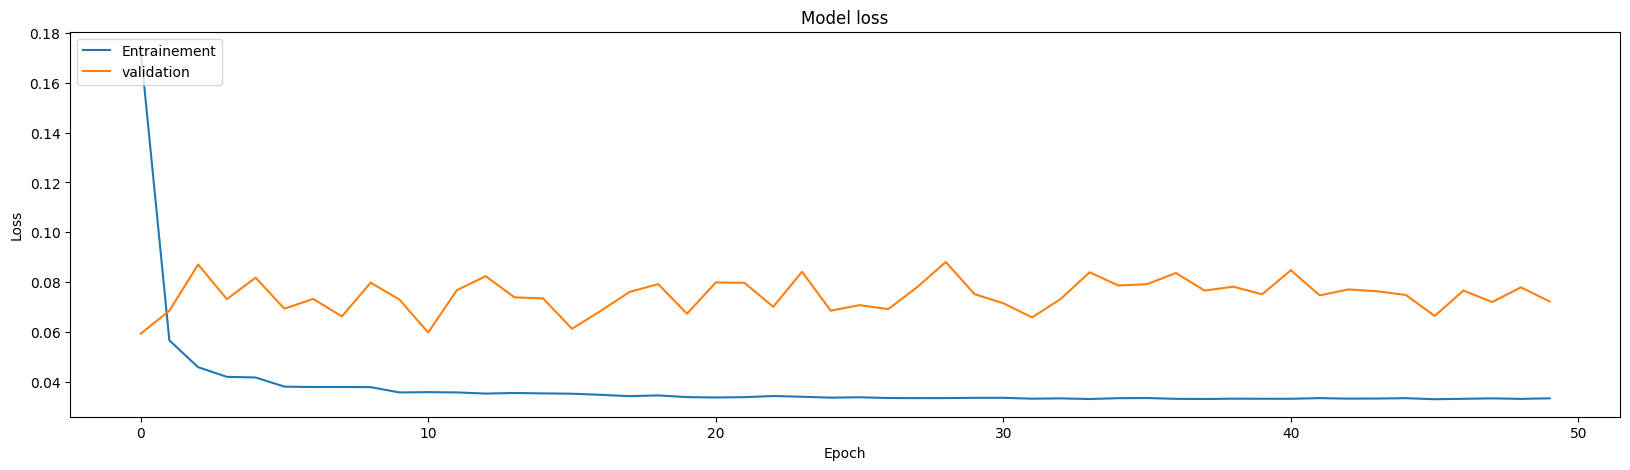

In [50]:
ploter_Erreur(model_train_Transformers)

In [53]:
# Evaluate the model on the test set
mse = model.evaluate(Xtest, Ytest, verbose=0)
print(f'Mean Squared Error on Test Set: {mse}')



Mean Squared Error on Test Set: 0.10139619559049606
